# Basic Operations on Images

In this tutorial we will cover the following:
* Getting Image Properties
* Pixel Access and Modification
* Image Channel Operations - Split & Merge
* ROI Selection
* Encoding and Decoding Images
* Making Borders for Images

---

## Standard Imports

In [29]:
import cv2
import numpy as np
from tutorial_utils.utils import *
from matplotlib import pyplot as plt
DATA_DIR = data_dir()

---

## Getting Image Properties


Some useful properties of the image object are:
* Height i.e. Number of rows of pixels
* Width i.e. Number of columns of pixels
* Channels i.e. Number of color channels
* Datatype of each channel of each pixel
* Total number of pixels (rows x columns) in the image

Grayscale images don't have multiple channels, so OpenCV just represents those images as a regular 2D array.
* For color images, `img.shape` returns (rows, columns, channels)
* For grayscale, `img.shape` returns (rows, columns)

In [30]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'starry_night.jpg')

# Image Dimensions
height, width, channels = img.shape
print("Image Dimensions : %s x %s" % (width, height))
print("Number of Channels : %s" % channels)

# Image Data Type
datatype = img.dtype
print("Image Data Type : %s" % datatype)

# Total Number of Pixels
sz = img.size
print("Total Number of Pixels in Image : %s" % sz)

Image Dimensions : 752 x 600
Number of Channels : 3
Image Data Type : uint8
Total Number of Pixels in Image : 1353600


---

### Pixel Access and Modification

Pixels can be accessed and modified using either array indexing, or the `item` method for access.
The latter is more efficient for accessing single elements. 

* For a color image, the pixel will be a `(B, G, R)` tuple.

* For a grayscale image, the pixel value will be a scalar.

* `item()` returns a scalar, thus requires the channel index that you want to access.

**Note**: Numpy previously also provided a `itemset()` method to set individual pixel values, but that has been deprecated.

---

#### Example : Getting Pixel Data

In [31]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'starry_night.jpg')

# Pixel Access

# Method 1 : Array indexing
px1 = img[100, 200] # Returns a tuple in case of color images, scalar in case of grayscale
px1_c = img[100, 200, 0] # Returns the scalar value of the specified channel of the pixel

px2 = img[100][200] # Also a valid way of indexing
px2_c = img[100][200][0]

# Method 2 : More efficient for single-item access
px3_c = img.item(100, 200, 0)

---
#### Example : Setting Pixel Data

In [32]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'starry_night.jpg')

img[100, 100] = [255, 255, 0]
img[100][200] = [255, 0, 255]

---

### Channel Operations

Sometimes you want to operate on a single channel of the image, i.e. you want a 2D array of the same dimensions as the original image, which only contains the intensity values of one of the channels.

To do this, you `split` the image into separate channels. After you process the channels as desired, you can `merge` them back together.

* Note that splitting and merging is an expensive operation, so you must only do that if absolutely necessary. In contrast, array indexing is much more efficient.
* You can use `np.dstack` to merge the channels, but it is much more slower than using `merge`.
* You can use array indexing to set all elements of a particular channel to a value of your choice

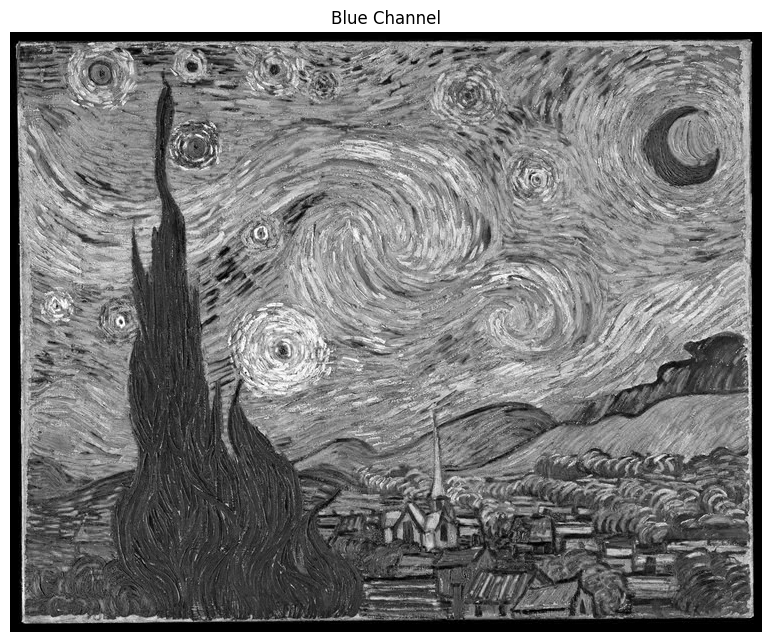

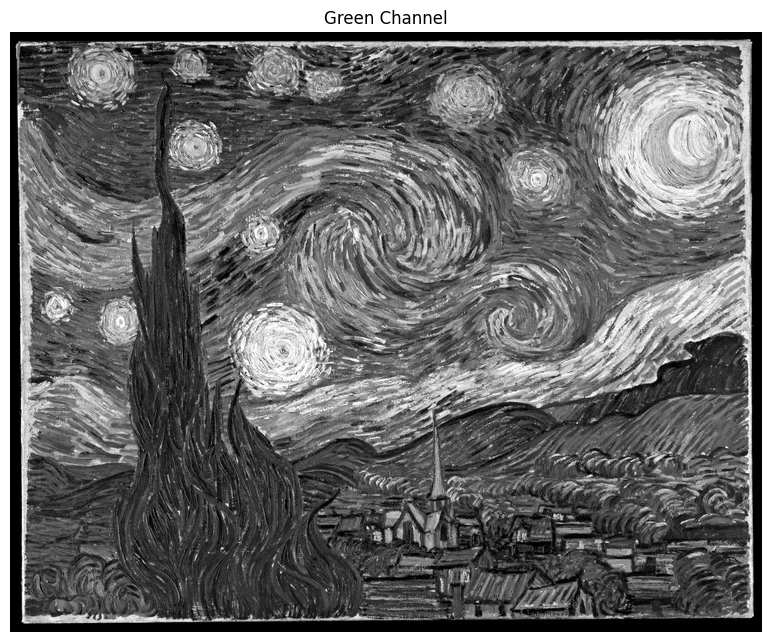

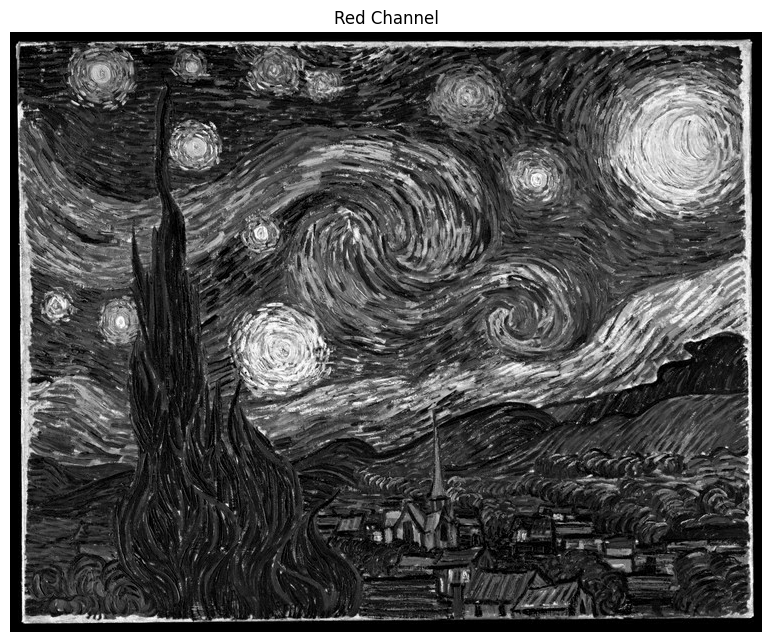

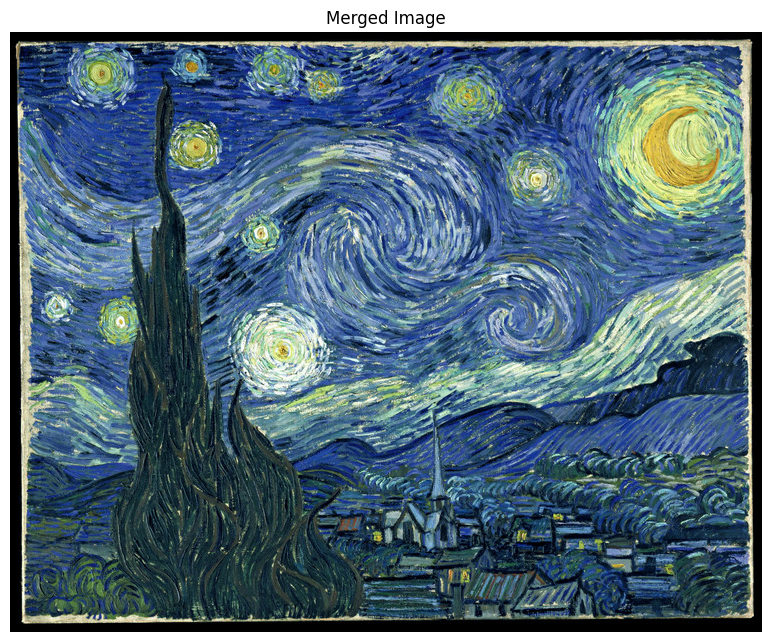

In [33]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'starry_night.jpg')


# Splitting Channels

b, g, r = img[:, :, 0], img[:, :, 1], img[:, : 2]  # Efficient
b, g, r = cv2.split(img) # Inefficient

cv2_imshow(b, "Blue Channel")
cv2_imshow(g, "Green Channel")
cv2_imshow(r, "Red Channel")


# Merging Back the channels
img_merged = cv2.merge((b,g,r))
cv2_imshow(img_merged, "Merged Image")


# Alternative, inefficient method
img_merged = np.dstack((b, g, r))


# Setting all elements of the Red Channel to 0
img[:, :, 2] = 0

---

### Region Of Interest (ROI)

Instead of operating on individual pixels, you can access and modify regions within an image. Such a region is called an ROI. Array indexing is the preferred method to do this.

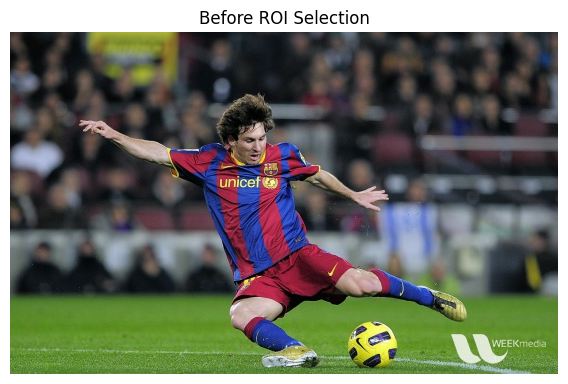

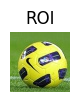

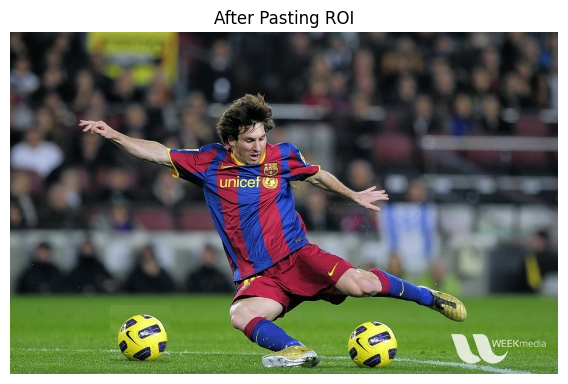

In [34]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'messi5.jpg')

# Display the image before selecting the ROI
cv2_imshow(img, "Before ROI Selection")

# Create an ROI 
ball = img[280:340, 330:390]

# Display the ROI
cv2_imshow(ball, "ROI")

# Paste the ROI at a position of choice in the image
img[273:333, 100:160] = ball

# Display the modified image
cv2_imshow(img, "After Pasting ROI")

---

#### Interactive ROI Selection

OpenCV provides `cv2.selectROI()` for use in interactive desktop applications. This lets the user choose a bounding box to select the ROI. 

An example of this is shown at [`01_Core_Operations/02_interactive_roi_selection.py`](https://github.com/ankurjay/opencv-python-tutorials/blob/main/01%20Core%20Operations/02_interactive_roi_selection.py). Note that this won't work in Jupyter Notebooks due to the interactive nature. 

---

### Encoding Images

When we work with OpenCV images (numpy arrays), we operate on uncompressed data.

OpenCV's `imencode()` function applies a specified image compression algorithm to the raw pixel data stored in the numpy array (image), and stores the compressed encoded data into a memory buffer (a byte array, or vector of bytes). 

The user provides a file extension string (e.g. `.jpg`, `.tiff`, `.png`) to this function, which lets the function determine which internal image format codec and compression algorithm will be used.

OpenCV uses various internal or third-party libraries (codecs) to perform the actual encoding/compression process:
* `libjpeg` for JPEG, lossy compression
* `libpng`, `zlib` for PNG lossless compression
* `libtiff` for TIFF

OpenCV internally stores color images in BGR order. But when `imencode` runs, it correctly formats the pixel data into the appropriate color space required by the target file format's standard (e.g. converting BGR to RGB or YCbCr for JPEG standard) before applying the compression.

`imencode` generates a `buffer` (numpy array of `np.uint8` data, which behaves as raw byte array) and a `bool` return value.

The `buffer` has some 'magic bytes' (also called file signatures) at its beginning that help a decoder identify its type.

---

### Decoding Images

OpenCV provides the `imdecode()` function to decode bytearrays into images. Raw bytes objects must be first converted into a 1-D numpy array of type `np.uint8`. This can be done using `np.frombuffer(data, np.uint8)`. This numpy array can then be input to `imdecode`.

The output of `imencode` can be directly fed to `imdecode`, but we cannot make that guarantee in general for any raw byte object, so it is safer to do this conversion irrespective of where the bytes came from.

---

#### Example

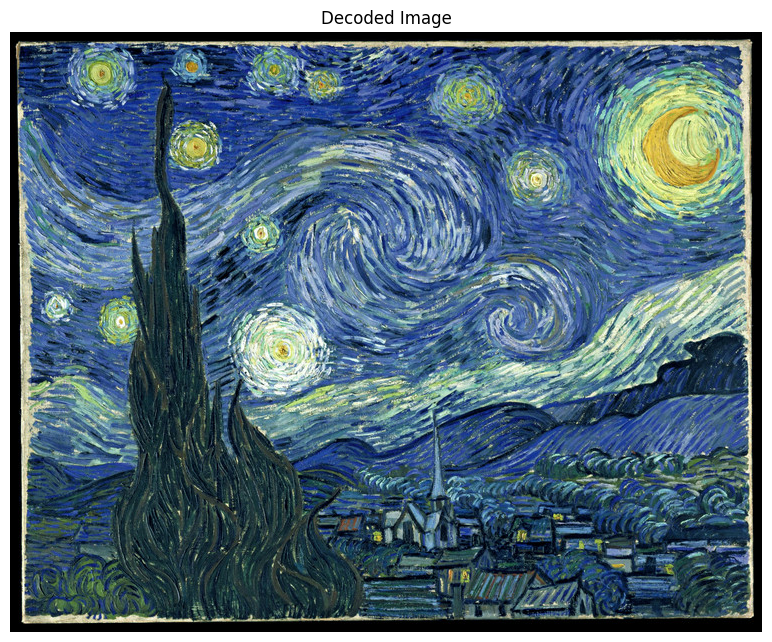

In [35]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'starry_night.jpg')


# Encode the image
ret, buffer = cv2.imencode('.png', img)


# Convert bytestring to np array of uint8
img_ar = np.frombuffer(buffer, np.uint8)
img_decoded = cv2.imdecode(img_ar, cv2.IMREAD_COLOR)


cv2_imshow(img_decoded, "Decoded Image")

---

### Making Borders for Images

OpenCV lets you create borders ('padding') around an image using `cv2.copyMakeBorder()`. This function takes the following arguments:
* Image
* top, bottom, left, right : border width corresponding to each edge, in pixels
* borderType : A flag defining what kind of border is to be added
* value : Color value (only for a `cv2.BORDER_CONSTANT` borderType)

When a border is created, it **increases** the dimensions of the image by the border widths.

The `borderType` can be one of the following:
```
cv2.BORDER_CONSTANT : a constant colored border

cv2.BORDER_REFLECT : reflect the border elements e.g. cba | abcdefghi | ihg

cv2.BORDER_REFLECT_101 or cv2.BORDER_DEFAULT : same as BORDER_REFLECT but does not include the edge element. e.g. cb | abcdefghi | hg

cv2.BORDER_REFPLICATE : Zero-order hold on the border element, i.e. the border element is replicated. e.g. aaaa | abcdefghi | iiii

cv2.BORDER_WRAP : Make the border 'periodic' e.g. ghi | abcdefghi | abc
```

---


#### Examples


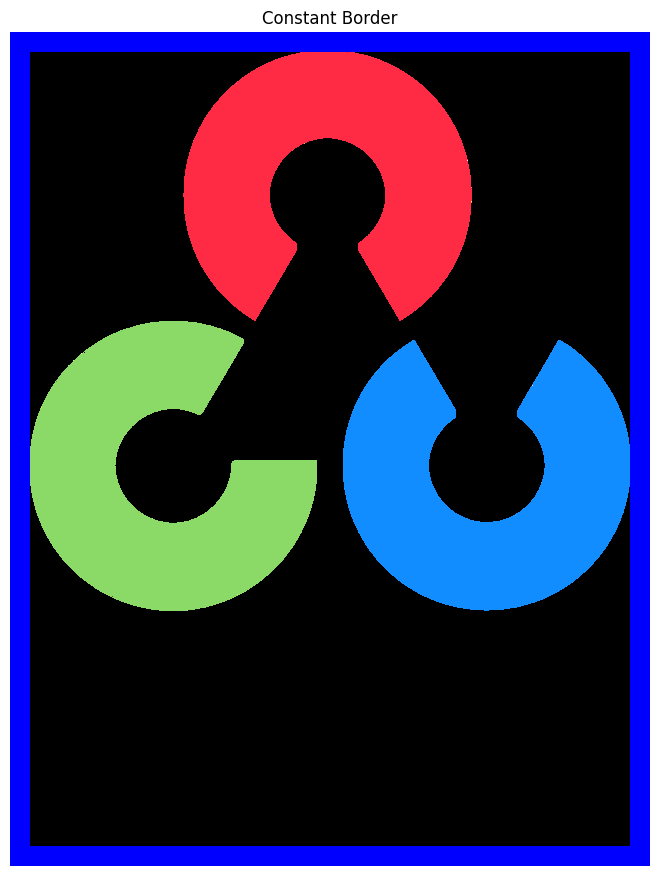

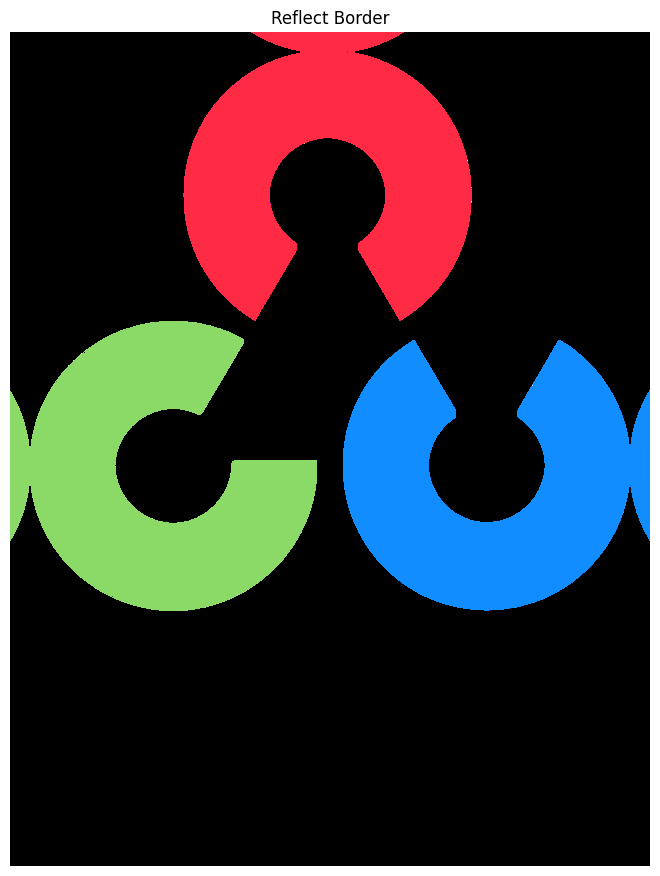

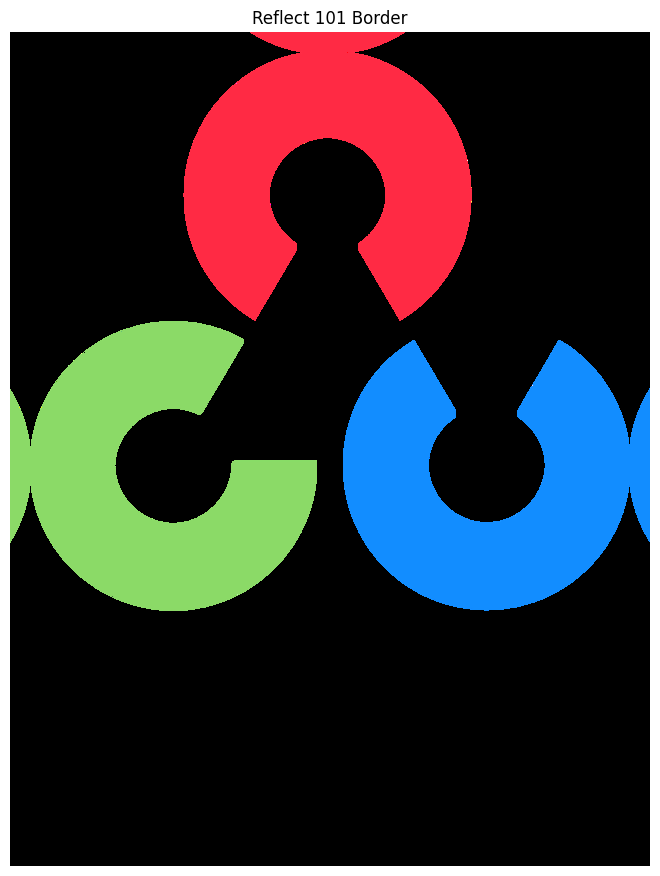

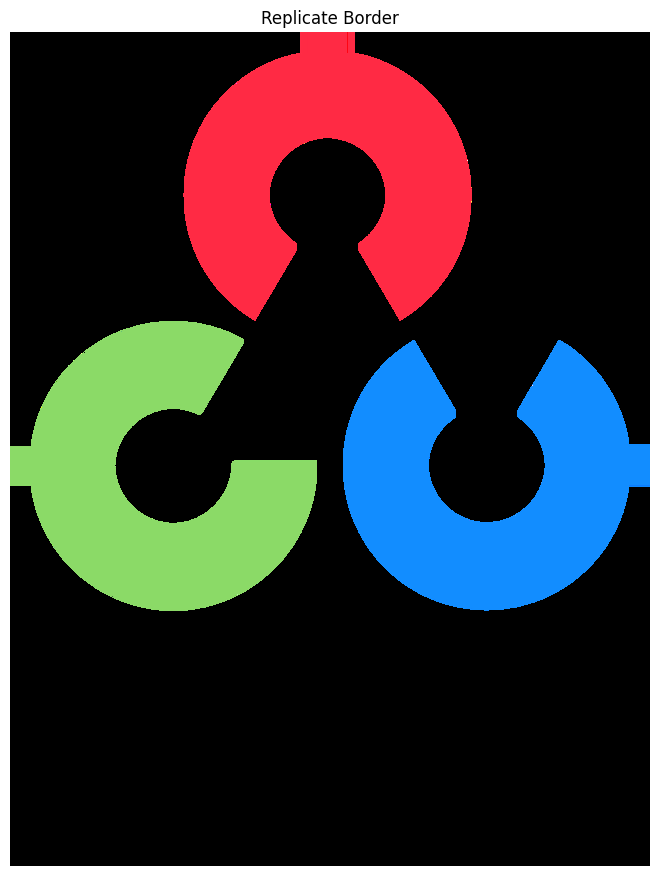

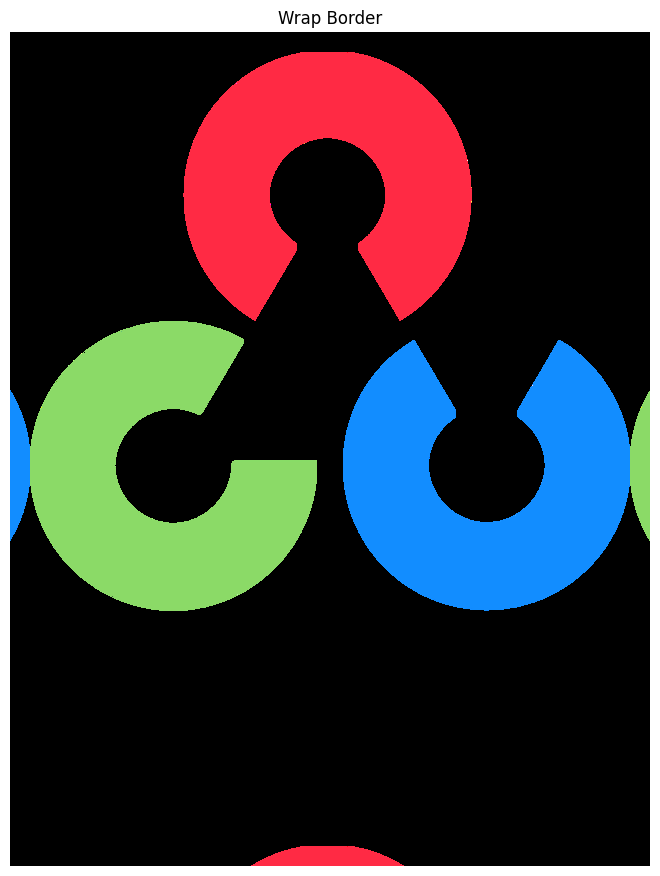

In [28]:
# Load a Color Image
img = cv2.imread(DATA_DIR + 'opencv-logo.png')

BLUE = [255, 0, 0]
BORDER_WIDTH = 20

# Apply various types of borders
constant = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_CONSTANT, value=BLUE)

reflect = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_REFLECT)

reflect101 = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_REFLECT_101)

replicate = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_REPLICATE)

wrap = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_WRAP)


# Display each image
cv2_imshow(constant, "Constant Border")
cv2_imshow(reflect, "Reflect Border")
cv2_imshow(reflect101, "Reflect 101 Border")
cv2_imshow(replicate, "Replicate Border")
cv2_imshow(wrap, "Wrap Border")